In [1]:
# install and test tensorflow env on my machine MacM1: https://www.youtube.com/watch?v=5DgWvU0p2bk
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import platform

print(f"Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"Numpy {np.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Platform: macOS-13.0-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
Pandas 1.5.0
Scikit-Learn 1.1.2
Numpy 1.23.2
GPU is available


In [2]:
from pathlib import Path
from PIL import Image
import albumentations as aug
import random
from matplotlib import pyplot as plt
import os

# Loading the data and Creating 8 classes annotation
## Data description
After we downloaded the Cityscapes dataset we discover it's content and give some breaf introduction here.

The folder dataset containes the folowing :

 - leftImg8bit : the images of the dataset, I rename it to images/
 - gtFine/ : contains the images, I rename this folder into masks/
 - test/, train/ and val/ : contains the the three splits of the dataset
 - berlin/, frankfurt/, munich/, ... : contains the images that corresponds to different cities
 - *_gtFine_color.png : contains the labels colors
 - *_gtFine_instanceIds.png : contains the instance ids
 - *_gtFine_labalIds.png : contains the label ids
 - *_gtFine_polygons.json : contains the polygon shapes
 

We are not going to use the polygon shapes, but we will use the instance ids to build the ground truth images.

The dataset contains :
 - 2975 train images
 - 500 validation images
 - 1525 test images

According to the Cityscapes dataset documentation, the images are of size 2048x1024 and are in RGB format.

We will not use the object labels (32 labels), but the 8 label categories : "void", "flat", "construction", "object", "nature", "sky", "human" and "vehicle".

In [3]:
# Let's load the images 
data_path = Path("data")
images_path = Path(data_path, "images")
masks_path = Path(data_path, "masks")

In [4]:
# Train dataset
train_input_img_paths = sorted(
    Path(images_path, "train").glob("**/*_leftImg8bit.png")
)
train_label_ids_img_paths = sorted(
    Path(masks_path, "train").glob("**/*_gtFine_labelIds.png")
)
train_label_color_img_paths = sorted(
    Path(masks_path, "train").glob("**/*_color.png")
)

# Validation dataset
val_input_img_paths = sorted(
    Path(images_path, "val").glob("**/*_leftImg8bit.png")
)
val_label_ids_img_paths = sorted(
    Path(masks_path, "val").glob("**/*_gtFine_labelIds.png")
)
val_label_colors_img_paths = sorted(
    Path(masks_path, "val").glob("**/*_color.png")
)

# Test dataset
test_input_img_paths = sorted(
    Path(images_path, "test").glob("**/*_leftImg8bit.png")
)
test_label_ids_img_paths = sorted(
    Path(masks_path, "test").glob("**/*_gtFine_labelIds.png")
)
test_label_colors_img_paths = sorted(
    Path(masks_path, "test").glob("**/*_color.png")
)

Let us write the files that we will need for our data generation, everything being ordonated:
 - train_input_img_paths
 - train_label_ids_img_paths
 - val_input_img_paths
 - val_label_ids_img_paths
 - test_input_img_paths
 - test_label_ids_img_paths

In [5]:
with open('data/train_images.txt', 'w') as f:
    f.write("\n".join(str(item) for item in train_input_img_paths))
with open('data/train_mask.txt', 'w') as f:
    f.write("\n".join(str(item) for item in train_label_ids_img_paths))
with open('data/val_images.txt', 'w') as f:
    f.write("\n".join(str(item) for item in val_input_img_paths))
with open('data/val_mask.txt', 'w') as f:
    f.write("\n".join(str(item) for item in val_label_ids_img_paths))
with open('data/test_images.txt', 'w') as f:
    f.write("\n".join(str(item) for item in test_input_img_paths))
with open('data/test_mask.txt', 'w') as f:
    f.write("\n".join(str(item) for item in test_label_ids_img_paths))

In [6]:
print('We have {0} train images'.format(len(train_input_img_paths)))
print('We have {0} validation images'.format(len(val_input_img_paths)))
print('We have {0} test images'.format(len(test_input_img_paths)))

We have 2975 train images
We have 500 validation images
We have 1525 test images


Next we take a random image and try to understand each file from the data.

In [7]:
rand_idx = np.random.randint(0, len(val_input_img_paths))
image_id = (
    str(val_input_img_paths[rand_idx])
    .split("/")[-1]
    .replace("_leftImg8bit.png", "")
)
img = np.array(Image.open(val_input_img_paths[rand_idx]))
ids_img = np.array(np.array(Image.open(val_label_ids_img_paths[rand_idx])))
img_size = img.shape
color_img = np.array(np.array(Image.open(val_label_colors_img_paths[rand_idx])))
ids_img_size = ids_img.shape
color_img_size = color_img.shape

print('The size image is: {0}'.format(img_size))
print('The size ids image is: {0}'.format(ids_img_size))
print('The size color image is: {0}'.format(color_img_size))

The size image is: (1024, 2048, 3)
The size ids image is: (1024, 2048)
The size color image is: (1024, 2048, 4)


Note that 
 - each image has the size of (1024, 2048) with dimension 3 that is the RGB.
 - the label_ids images sizes are (1024, 2048) that tells us the label associated to that pixel
 - color image has the size of (1024, 2048) with dimension 4. The first 3 dimensions is the RGB and the fourth layer is the alpha chanel which is added to allow the transparency of the image (it does not change the color of the pixel). Also, we note that this is equal to 255 for all the times, there is why we can delete it.
 
Also we observe there is 1024 * 2048 = 2097152 pixels in the image.

Let us see the color of the first pixel in the image

In [8]:
img[0,0,:]

array([18, 27, 19], dtype=uint8)

Let us see the ids of the first pixel in the labelIds image. This correspons to 3, that meens that the first pixel is attributed to the **void** cathegory.

In [9]:
ids_img[0,0]

3

In [10]:
color_img = color_img[:,:,:3]
color_img_size = color_img.shape
print('The size color image is: {0}'.format(color_img_size))

The size color image is: (1024, 2048, 3)


In [11]:
1024*2048

2097152

In [12]:
color_img.reshape(-1,3).shape

(2097152, 3)

## Colors in the image

In [13]:
colours, counts = np.unique(color_img.reshape(-1,3), axis=0, return_counts=1)
for j in range(len(colours)):
    print('{0}/{1}:{2}'.format(j, colours[j], counts[j]))

0/[0 0 0]:122198
1/[ 0  0 70]:7868
2/[  0   0 142]:214181
3/[70 70 70]:172725
4/[ 70 130 180]:69622
5/[102 102 156]:3139
6/[107 142  35]:641685
7/[111  74   0]:434
8/[128  64 128]:668884
9/[152 251 152]:297
10/[153 153 153]:9576
11/[190 153 153]:2216
12/[220 220   0]:3242
13/[244  35 232]:181085


## Image anotation

In [14]:
def count_label_anotation(ann_img):
    colours, counts = np.unique(ann_img, return_counts=1)
    for j in range(len(colours)):
        print('{0}/{1}:{2}'.format(j, colours[j], counts[j]))

In [15]:
count_label_anotation(ids_img)

0/1:81534
1/3:31634
2/4:9030
3/5:434
4/7:668884
5/8:181085
6/11:172725
7/12:3139
8/13:2216
9/17:9576
10/20:3242
11/21:641685
12/22:297
13/23:69622
14/26:214181
15/27:7868


## Transform 8 classes annotation

In [16]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
 }

cats_replace = {0: [0, 1, 2, 3, 4, 5, 6],
 1: [7, 8, 9, 10],
 2: [11, 12, 13, 14, 15, 16],
 3: [17, 18, 19, 20],
 4: [21, 22],
 5: [23],
 6: [24, 25],
 7: [26, 27, 28, 29, 30, 31, 32, 33, -1]
 }

cats_id = {
 'void': 0,
 'flat': 1,
 'construction': 2,
 'object': 3,
 'nature': 4,
 'sky': 5,
 'human':6,
 'vehicle': 7
}

cats_colors = {
 'void': (0,0,0),
 'flat': (50,50,50),
 'construction': (150,150,150),
 'object': (255,0,0),
 'nature': (0,255,0),
 'sky': (0,0,255),
 'human':(200,200,0),
 'vehicle': (150,0,200)
}

In [17]:
mask_labelids = pd.DataFrame(ids_img)
for new_value, old_value in cats_replace.items():
    mask_labelids = mask_labelids.replace(old_value, new_value);
mask_labelids = mask_labelids.to_numpy()

In [18]:
count_label_anotation(mask_labelids)

0/0:122632
1/1:849969
2/2:178080
3/3:12818
4/4:641982
5/5:69622
6/7:222049


Observe that there is no sky annotated in the picture. Let us show the original picture with the annotation picture.

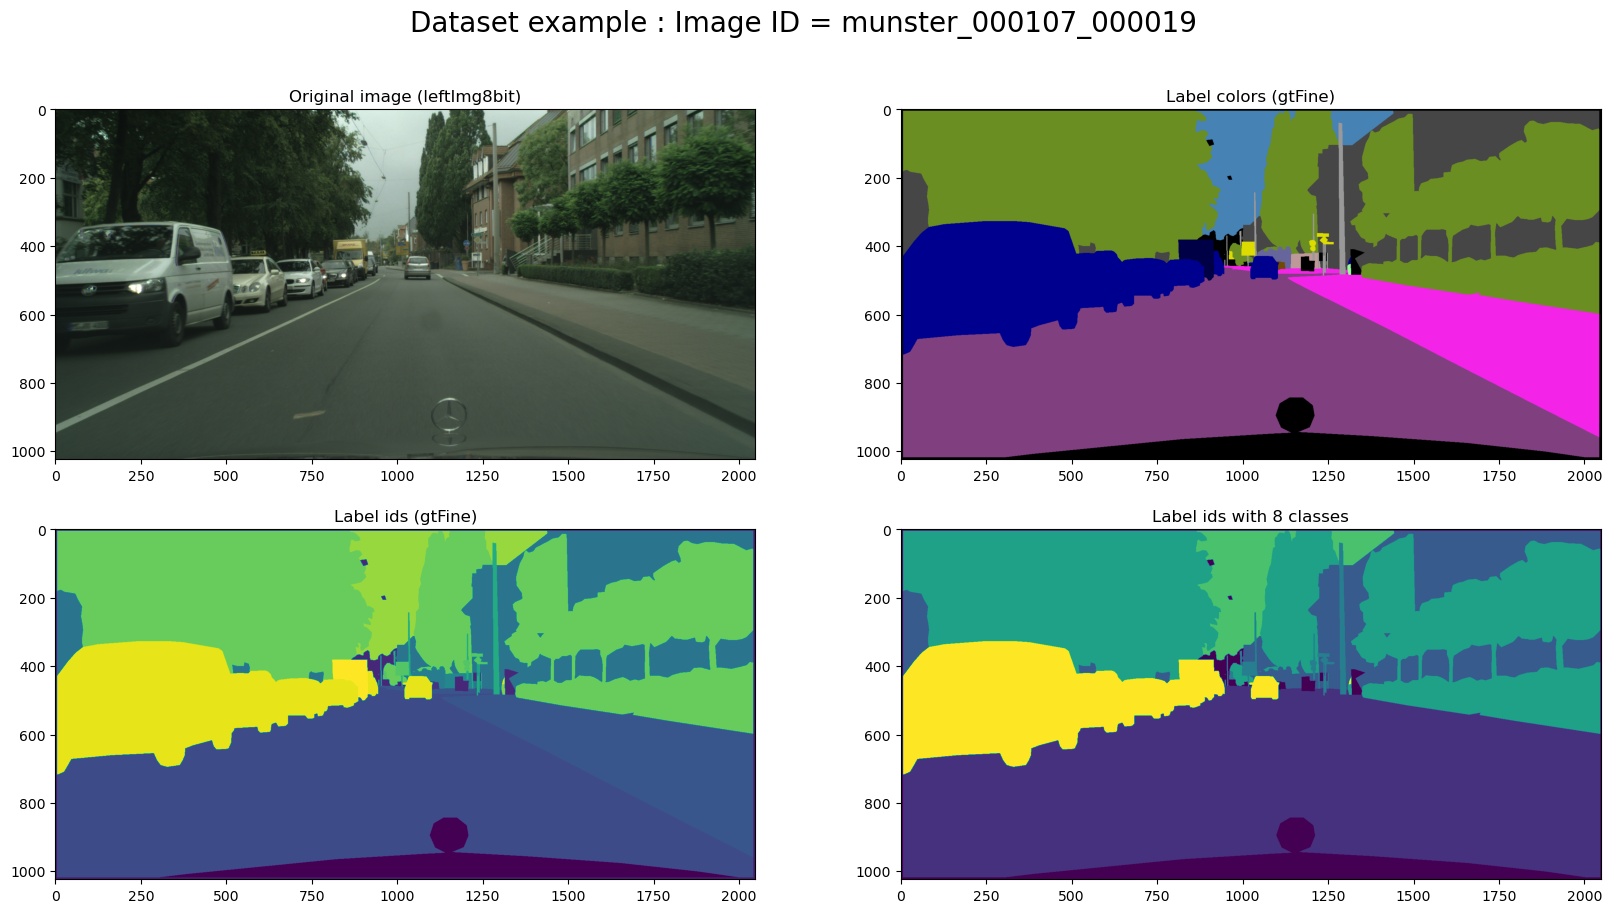

In [19]:
# plot images
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, 10),
)
fig.suptitle(f"Dataset example : Image ID = {image_id}", fontsize=20)

ax[0, 0].title.set_text("Original image (leftImg8bit)")
ax[0, 0].imshow(img)

ax[0, 1].title.set_text("Label colors (gtFine)")
ax[0, 1].imshow(color_img)

ax[1, 0].title.set_text("Label ids (gtFine)")
ax[1, 0].imshow(np.array(ids_img))

ax[1, 1].title.set_text("Label ids with 8 classes")
ax[1, 1].imshow(np.array(mask_labelids))

plt.show()

In [20]:
ids_img

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint8)

# Augmentation images
Let us now see how we can augment the images. We will take the original image and the label ids with 8 annotated classes and we will use the albumentations class to augment the images.

In [21]:
transform = aug.Compose(
    [
        aug.OneOf(  # Color augmentations
            [
                aug.RandomBrightnessContrast(),
                aug.RandomGamma(),
                aug.RandomToneCurve(),
            ]
        ),
        aug.OneOf(  # Camera augmentations
            [
                aug.MotionBlur(),
                aug.GaussNoise(),
            ]
        ),
        aug.OneOf(  # Geometric augmentations
            [
                aug.HorizontalFlip(),
                aug.RandomCrop(
                    width=int(img_size[1] / random.uniform(1.0, 2.0)),
                    height=int(img_size[0] / random.uniform(1.0, 2.0)),
                ),
                aug.SafeRotate(
                    limit=15,
                ),
            ]
        ),
    ]
)

#img = np.array(Image.open(val_input_img_paths[rand_idx]))
#mask = np.array(Image.open(val_label_ids_img_paths[rand_idx]))

augmented = transform(
    image=img,
    mask=mask_labelids,
)

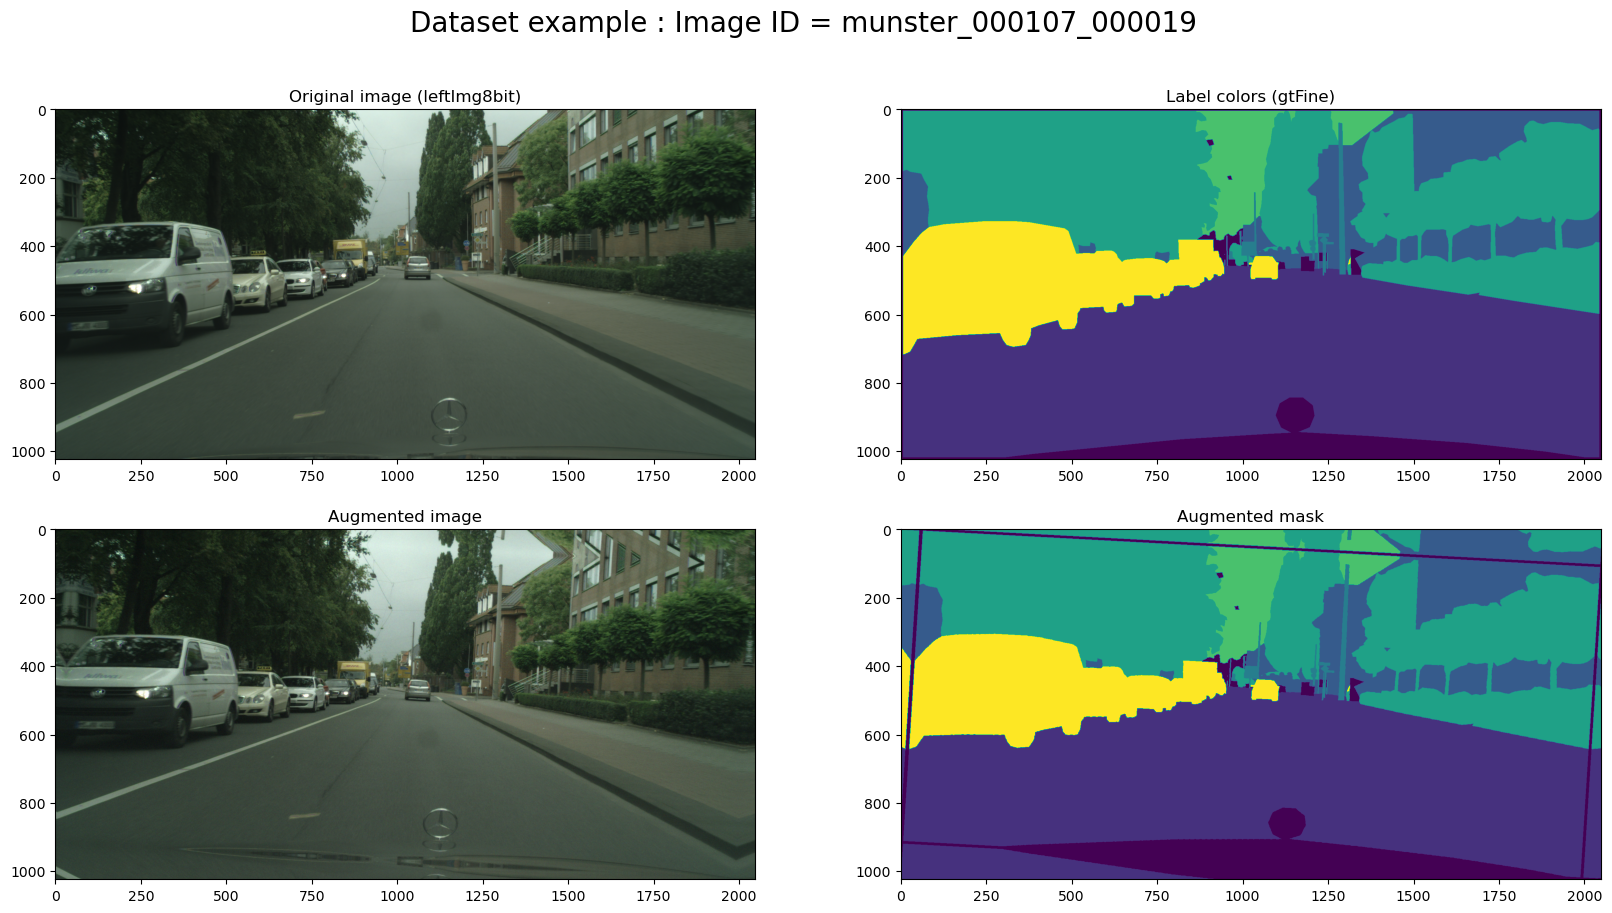

In [22]:
# plot images
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, 10),
)
fig.suptitle(f"Dataset example : Image ID = {image_id}", fontsize=20)

ax[0,0].title.set_text("Original image (leftImg8bit)")
ax[0,0].imshow(img)

ax[0,1].title.set_text("Label colors (gtFine)")
ax[0,1].imshow(np.array(mask_labelids))

ax[1,0].title.set_text("Augmented image")
ax[1,0].imshow(np.array(augmented["image"]))

ax[1,1].title.set_text("Augmented mask")
ax[1,1].imshow(np.array(augmented["mask"]))

plt.show()

Observe an augmantation as a crop is done here.

https://github.com/divamgupta/image-segmentation-keras

# Data Generator example

Observe that we resize the image 8 times, that is (2048, 1024) / 8 in loading the image function.

In [178]:
def load_img(img_list, img_size=(256,128), ismask = False):
    weight = img_size[0]
    height = img_size[1]
    
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'png'):
            if (weight==None) and (height==None) :
                # do not do resizing
                image = np.array(Image.open(image_name))
                image = image.astype(np.float32)
            elif (weight!=None) or (height!=None):
                # do resizing
                # downsize the image with an ANTIALIAS filter (gives the highest quality)
                if ismask:
                    # the mask image is loaded
                    img = Image.open(image_name) #width , height = (2048, 1024) / 8
                    #img = img.resize((256,128), Image.Resampling.LANCZOS)
                    image = np.array(img)
                    
                    mask = np.zeros((1024,2048,8))
                    for cat in cats_id:
                        mask[:,:,cats_id[cat]] = np.logical_or(mask[:,:,cats_id[cat]],(image==cats_id[cat]))
                    image = mask
                else:
                    img = Image.open(image_name) #width , height = (2048, 1024) / 8
                    img = img.resize((256,128), Image.Resampling.LANCZOS)
                    image = np.array(img)
                    image = image.astype(np.float32)
            images.append(image)
    images = np.array(images)
    
    return(images)

In [179]:
def imageLoader(img_list, mask_list, batch_size):
    '''
    img_list - the list of full names images
    mask_list - the list of full names masks
    batch_size - batch size we want to provide
    '''
    L = len(img_list)
    

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            
            X = load_img(img_list[batch_start:limit], ismask = False)
            Y = load_img(mask_list[batch_start:limit], ismask = True)

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


## Test generator

In [180]:
path_to_train = 'data/train_images.txt'
path_to_mask = 'data/train_mask.txt'
path_to_val = 'data/val_images.txt'
path_to_val_mask = 'data/val_mask.txt'
with open(path_to_train) as f:
    contents_train = f.read().splitlines()
with open(path_to_mask) as f:
    contents_mask = f.read().splitlines()
with open(path_to_val) as f:
    contents_val = f.read().splitlines()
with open(path_to_val_mask) as f:
    contents_val_mask = f.read().splitlines()

In [181]:
contents_train[13:16]

['data/images/train/aachen/aachen_000013_000019_leftImg8bit.png',
 'data/images/train/aachen/aachen_000014_000019_leftImg8bit.png',
 'data/images/train/aachen/aachen_000015_000019_leftImg8bit.png']

In [182]:
contents_mask[13:16]

['data/masks/train/aachen/aachen_000013_000019_gtFine_labelIds.png',
 'data/masks/train/aachen/aachen_000014_000019_gtFine_labelIds.png',
 'data/masks/train/aachen/aachen_000015_000019_gtFine_labelIds.png']

We see that the mask files corresponds to the images files. Now we will test our data generator and see if the image loader loads correctly.

In [183]:
batch_size = 2

train_img_datagen = imageLoader(contents_train, contents_mask, batch_size)
val_img_datagen = imageLoader(contents_val, contents_val_mask, batch_size)

In [184]:
#Verify generator....
img, msk = train_img_datagen.__next__()

In [185]:
img.max()

255.0

In [186]:
np.argmax(msk[0], axis=2)

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [187]:
print('the shape of image read by generator: {0}'.format(img.shape))
print('the shape of mask read by generator: {0}'.format(msk.shape))

the shape of image read by generator: (2, 128, 256, 3)
the shape of mask read by generator: (2, 1024, 2048, 8)


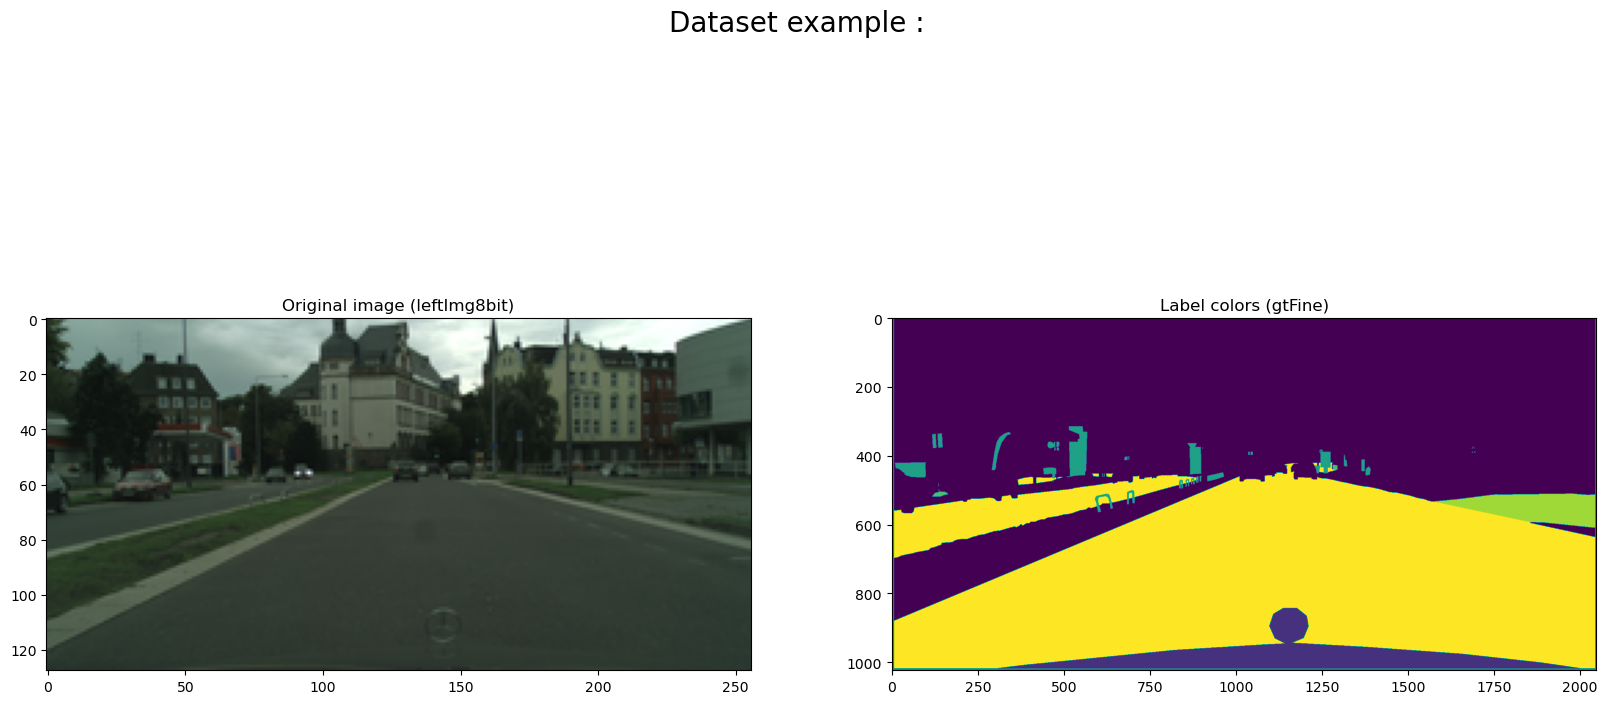

In [196]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask = np.argmax(test_mask, axis=2)

fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 10),
)
fig.suptitle(f"Dataset example :", fontsize=20)

ax[0].title.set_text("Original image (leftImg8bit)")
ax[0].imshow(test_img/255)

ax[1].title.set_text("Label colors (gtFine)")
ax[1].imshow(test_mask)

plt.show()

In [154]:
np.unique(test_mask)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [157]:
np.unique(test_mask)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [158]:
test_mask

array([[5, 0, 0, ..., 0, 0, 6],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 7, 7, ..., 7, 7, 5],
       [4, 7, 7, ..., 7, 7, 5],
       [3, 5, 5, ..., 5, 5, 4]])

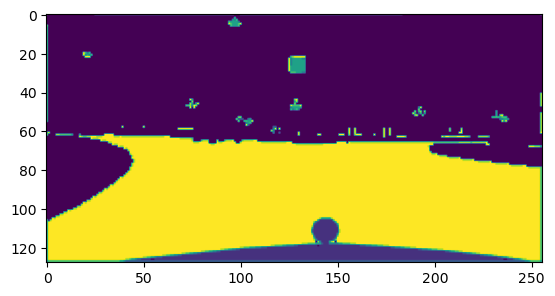

In [155]:
plt.imshow(test_mask)

In [151]:
test_mask.shape

(128, 256)

In [152]:
colours, counts = np.unique(test_mask, return_counts=1)

for j in range(len(colours)):
    print(f"    {colours[j]}: {counts[j]}")

    0: 18016
    1: 1079
    2: 257
    3: 71
    4: 165
    5: 251
    6: 504
    7: 12425


# Modeling
## Create 2DUNET

In [33]:
# inspired from https://youtu.be/ScdCQqLtnis

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  tf.keras.initializers.HeNormal() #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    #model.summary()
    
    return model

#Test if everything is working ok. 
nr_classes = 8
nr_channels = 1
height, weight = 128, 256
model = simple_unet_model(height, weight, nr_channels, nr_classes)
print(model.input_shape)
print(model.output_shape)

Metal device set to: Apple M1 Pro


2022-10-29 05:32:21.257930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-29 05:32:21.258045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/oc_8/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


(None, 128, 256, 1)
(None, 128, 256, 8)


In [34]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [35]:
# Define loss, metrics, and optimizer to be used for training
dice_loss = sm.losses.DiceLoss(class_weights = [1/8]*8) # I attribute for know the equal class weights for all the class weights
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)

In [ ]:
#######################################################################
#Fit the model 

steps_per_epoch = len(contents_train)//batch_size
val_steps_per_epoch = len(contents_val)//batch_size

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=256, 
                          IMG_CHANNELS=1, 
                          num_classes=8)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

#print(model.input_shape)
#print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('voiture_autonomie_1.hdf5')

Epoch 1/100


2022-10-29 05:33:16.183379: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-29 05:33:17.048651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
partition = {}
path_to_train = 'data/train_images.txt'
path_to_valid = 'data/val_images.txt'
path_to_mask = 'data/train_mask.txt'
with open(path_to_train) as f:
    contents_train = f.readlines()
with open(path_to_valid) as f:
    contents_validation = f.readlines()
with open(path_to_mask) as f:
    contents_mask = f.readlines()

partition['train'] = contents_train
partition['validation'] = contents_validation


In [13]:
contents_mask

['/Users/bartcus/Documents/GitHub/OC-projects/oc_8/data/masks/train/zurich/zurich_000072_000019_gtFine_color.png\n',
 '/Users/bartcus/Documents/GitHub/OC-projects/oc_8/data/masks/train/zurich/zurich_000022_000019_gtFine_labelIds.png\n',
 '/Users/bartcus/Documents/GitHub/OC-projects/oc_8/data/masks/train/zurich/zurich_000118_000019_gtFine_instanceIds.png\n',
 '/Users/bartcus/Documents/GitHub/OC-projects/oc_8/data/masks/train/zurich/zurich_000036_000019_gtFine_instanceIds.png\n',
 '/Users/bartcus/Documents/GitHub/OC-projects/oc_8/data/masks/train/zurich/zurich_000017_000019_gtFine_labelIds.png\n',
 '/Users/bartcus/Documents/GitHub/OC-projects/oc_8/data/masks/train/zurich/zurich_000073_000019_gtFine_instanceIds.png\n',
 '/Users/bartcus/Documents/GitHub/OC-projects/oc_8/data/masks/train/zurich/zurich_000003_000019_gtFine_color.png\n',
 '/Users/bartcus/Documents/GitHub/OC-projects/oc_8/data/masks/train/zurich/zurich_000028_000019_gtFine_instanceIds.png\n',
 '/Users/bartcus/Documents/GitHub/

In [ ]:
import numpy as np

from keras.models import Sequential
from my_classes import DataGenerator

# Parameters
params = {'dim': (32,32,32),
          'batch_size': 64,
          'n_classes': 6,
          'n_channels': 1,
          'shuffle': True}

# Datasets
partition = # IDs
labels = # Labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Design model
model = Sequential()
[...] # Architecture
model.compile()

# Train model on dataset
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6)